# Modelación de tópicos
---

In [26]:
import time, re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

## Web scrapping
---

In [27]:
# Define numero aleatorios entre 3 y 7
def distriProb_lognorm():
  pdf = np.random.lognormal(mean=2.0, sigma=0.5, size=(1))
  if pdf<3  or pdf>7:
    pdf=np.random.randint(3,6)
  return float(pdf)

In [28]:
# Define el nevegador
options = webdriver.ChromeOptions()
#options.add_argument('--headless')
#options.add_argument('--no-sandbox')
#options.add_argument('--disable-dev-shm-usage')
chrome_driver = "./chromedriver"
options.binary_location = "/usr/bin/google-chrome-stable"
webpage_target = 'https://www.sciencedirect.com/'
driver = webdriver.Chrome(options = options)

In [35]:
# Colocamos el link de la pagina donde queremos hacer la busqueda
try:
    driver.get(webpage_target)
except:
    print('Hubo un error de conexion intentando de nuevo...')
    time.sleep(distriProb_lognorm())
    driver.refresh()
    driver.get(webpage_target)

In [36]:
# Enviamos un query de busqueda a la barra de busqueda
search_box_id = 'qs'
query = 'eddies AND ocean AND lagrangian'
search_box = driver.find_element(By.ID, search_box_id)
search_box.send_keys(query)
search_box.send_keys(Keys.RETURN) #click enter

In [37]:
# Filtramos los resultados por los que corresponden a reviewa
try:
    time.sleep(distriProb_lognorm())
    reviews = driver.find_element(By.ID, "articleTypes-REV")
    driver.execute_script("arguments[0].click();", reviews)
except:
    print('Hubo un error de conexion intentando de nuevo...')
    time.sleep(10)
    driver.refresh()
    reviews = driver.find_element(By.ID, "articleTypes-REV")
    driver.execute_script("arguments[0].click();", reviews)
# Filtramos por ciencias de la Tierra
"""try:
    time.sleep(distriProb_lognorm())
    earth = driver.find_element(By.ID, "subjectAreas-1900")
    driver.execute_script("arguments[0].click();", earth)
except:
    print('Hubo un error de conexion intentando de nuevo...')
    time.sleep(10)
    driver.refresh()
    time.sleep(10)
    show_more = driver.find_element(By.CSS_SELECTOR, '[aria-label="Show more subjectAreas filters"]')
    driver.execute_script("arguments[0].click();", show_more)
    time.sleep(distriProb_lognorm())
    earth = driver.find_element(By.ID, "subjectAreas-1900")
    driver.execute_script("arguments[0].click();", earth)"""

'try:\n    time.sleep(distriProb_lognorm())\n    earth = driver.find_element(By.ID, "subjectAreas-1900")\n    driver.execute_script("arguments[0].click();", earth)\nexcept:\n    print(\'Hubo un error de conexion intentando de nuevo...\')\n    time.sleep(10)\n    driver.refresh()\n    time.sleep(10)\n    show_more = driver.find_element(By.CSS_SELECTOR, \'[aria-label="Show more subjectAreas filters"]\')\n    driver.execute_script("arguments[0].click();", show_more)\n    time.sleep(distriProb_lognorm())\n    earth = driver.find_element(By.ID, "subjectAreas-1900")\n    driver.execute_script("arguments[0].click();", earth)'

In [38]:
# Definimos 100 articulos por pagina
time.sleep(distriProb_lognorm())
xpath_100 = "//a[@class='anchor' and @data-aa-name='srp-100-results-per-page']"
first_100 = driver.find_element(By.XPATH, xpath_100)
driver.execute_script("arguments[0].click();", first_100)

/tmp/ipykernel_243000/140653954.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pdf)


In [39]:
# Extreamos el html
time.sleep(distriProb_lognorm())
soup = BeautifulSoup(driver.page_source, 'html.parser')
art_html = soup.find_all('a', 'anchor result-list-title-link u-font-serif text-s anchor-default', 'rev')
pages_html = soup.find(id="srp-pagination")
n_pg = re.findall(r'Page\s\d of\s(\d+)', str(pages_html))[0]
link_list = [link.get('href') for link in art_html]
# Itera sobre cada pagina de los resultados de busqueda
for _ in range(int(n_pg)-1):
    # Siguiente pagina
    time.sleep(distriProb_lognorm())
    xpath_next = "//a[@class='anchor' and @data-aa-name='srp-next-page']"
    next_100 = driver.find_element(By.XPATH, xpath_next)
    driver.execute_script("arguments[0].click();", next_100)
    # Extreamos el html
    time.sleep(distriProb_lognorm())
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    art_html = soup.find_all('a', 'anchor result-list-title-link u-font-serif text-s anchor-default', 'rev')
    # Extreamos el link del html
    next_link_list = [link.get('href') for link in art_html]
    # Se añade a una lista
    link_list.extend(next_link_list)
    print(len(link_list))

200
247


In [41]:
df = pd.DataFrame({'link': link_list})
df['link'] = df['link'].map(lambda link: 'https://www.sciencedirect.com'+link)
# abstracts = []
# titles = []
titles_abstracts = {}
for link in df['link']:
    #driver = webdriver.Chrome(executable_path = chrome_driver, options = options)
    time.sleep(distriProb_lognorm())
    driver.get(link)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    html_title = soup.find_all('span', 'title-text')
    title_text = re.findall(r"(?<=\>).+(?=<)", str(html_title))
    # titles.extend(title_text)
    rexp = re.compile(r"(?<=\d\"\>)\w[A-Za-z\s$&+,:;=?@#|'.^*()%!-’]+\.")
    html_abstract = soup.find_all('div', 'abstract author')
    abstract_text = re.findall(rexp, str(html_abstract))
    # abstracts.extend(abstract_text)
    regex_list = [r"<p>(.*?)</p>", r'<p id="[^"]*">(.*?)</p>']
    n_iter = 0
    while len(abstract_text) == 0:
        if len(html_abstract) == 0:
            abstract_text = ["empty_abstract"]
        else:
            abstract_text = re.findall(regex_list[n_iter], str(html_abstract))
            n_iter += 1
    # Add new abstract to dict
    titles_abstracts[title_text[0]] = abstract_text[0]
    print(len(titles_abstracts), end='\r')
df['titles'] = titles_abstracts.keys()
df['abstracts'] = titles_abstracts.values()
df.to_csv('abstract_pln.csv')

/tmp/ipykernel_243000/140653954.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pdf)


In [45]:
df

,link,titles,abstracts
0,https://www.sciencedirect.com/science/article/...,Assessment of a Lagrangian model using traject...,"In the Tropical Atlantic Ocean, we assessed th..."
1,https://www.sciencedirect.com/science/article/...,Marine life at Lagrangian fronts,Many ocean fronts are known to feature enhance...
2,https://www.sciencedirect.com/science/article/...,Lagrangian studies of wave-induced flows in a ...,A review of the Lagrangian approach to wave-in...
3,https://www.sciencedirect.com/science/article/...,Lagrangian ocean analysis: Fundamentals and pr...,Lagrangian analysis is a powerful way to analy...
4,https://www.sciencedirect.com/science/article/...,Generalized Lagrangian coherent structures,The notion of a Lagrangian Coherent Structure ...
...,...,...,...
242,https://www.sciencedirect.com/science/article/...,Heat transfer—a review of 1987 literature,empty_abstract
243,https://www.sciencedirect.com/science/article/...,Nonlinear drift waves and transport in magneti...,Recent developments in the physics of nonlinea...
244,https://www.sciencedirect.com/science/article/...,The confrontation between general relativity a...,The status of experimental tests of general re...
245,https://www.sciencedirect.com/science/article/...,Heat transfer—a review of 1980 literature,empty_abstract


In [42]:
titles_abstracts.keys()

dict_keys(['Assessment of a Lagrangian model using trajectories of oceanographic drifters and fishing devices in the Tropical Atlantic Ocean', 'Marine life at Lagrangian fronts', 'Lagrangian studies of wave-induced flows in a viscous ocean', 'Lagrangian ocean analysis: Fundamentals and practices', 'Generalized Lagrangian coherent structures', 'Revisiting the circulation of the East Australian Current: Its path, separation, and eddy field', 'Statistics from Lagrangian observations', 'A tutorial on dynamical systems concepts applied to Lagrangian transport in oceanic flows defined as finite time data sets: Theoretical and computational issues', 'Incorporating tides and internal gravity waves within global ocean general circulation models: A review', 'Antarctic icebergs melt over the Southern Ocean: Climatology and impact on sea ice', 'Will high-resolution global ocean models benefit coupled predictions on short-range to climate timescales?', 'Indigenized Indian Drifting Buoys with INSAT 

## Preprocesamiento
---

In [43]:
import nltk
from nltk.probability import FreqDist

In [48]:
# Creamos nuestro corpus
corpus = df["abstracts"].tolist()

In [49]:
# Definimos el tokenizador
wpt = nltk.WordPunctTokenizer()
# Definimos las stopwords
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['review', 'highlight', 'highlights', 'research', 'study', 'studies', 'also'])

# Definimos el preprocesamiento
def preprocess(doc):
    # Se eliminan caracteres especiales
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    # Se convierten los téxtos a minúsculas
    doc = doc.lower().strip()
    tokens = wpt.tokenize(doc)
    # Se eliminan las stopwords
    tokens = [token for token in tokens
              if token not in stop_words and len(token) > 2]
    # Retornamos una versión filtrada del texto
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /home/mofoko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
# Preprocesamos el texto
norm_corpus = list(map(preprocess, corpus))
norm_corpus[0]

'tropical atlantic ocean assessed accuracy lagrangian model ichthyop forced velocity fields hydrodynamical model croco two different remote sensing products globcurrent oscar using trajectories oceanographic drifters additionally evaluated possibility expand drifters data using trajectories gpsbuoy equipped drifting fish aggregating devices fads observed simulated trajectories compared terms spatial distribution velocity distribution nondimensional skill score drifters fads globcurrent oscar products lead similar performances croco modelouputs broad studied domain gulf guinea however croco model performed significantly better two parent solution croco benefited communication child grid finer resolution region average simulations lead underestimation drifter fad velocities likely spatial resolutions forcing products insufficient time frequency produced low resolve relevant oceanic processes properly found low skill models simulate fad trajectories possibly devices vertical structure pre

## EDA
---

In [51]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

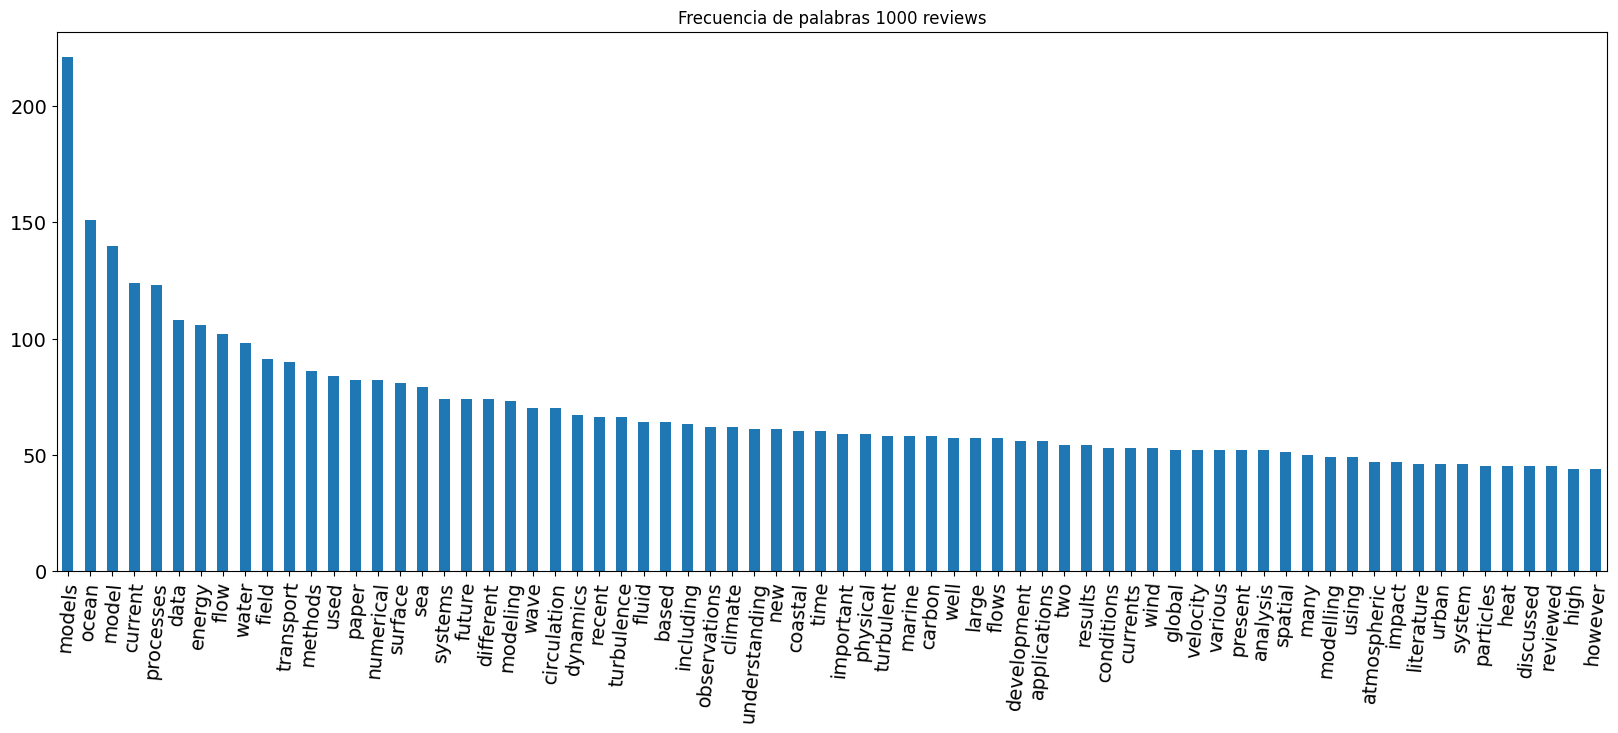

In [52]:
# Definimos el tokenizador
tokenizer = nltk.WordPunctTokenizer()
# Toquenizamos por palabra
word_tokens = tokenizer.tokenize(' '.join(norm_corpus))
# Creamos un grafico de frecuencias de palabras
frec_words = FreqDist(word_tokens)
fig = plt.figure(figsize =(20, 7))
pd.Series(dict(frec_words)).sort_values(ascending=False)[:70].plot(kind='bar', rot=85, fontsize=14, 
                                                                 title='Frecuencia de palabras 1000 reviews');

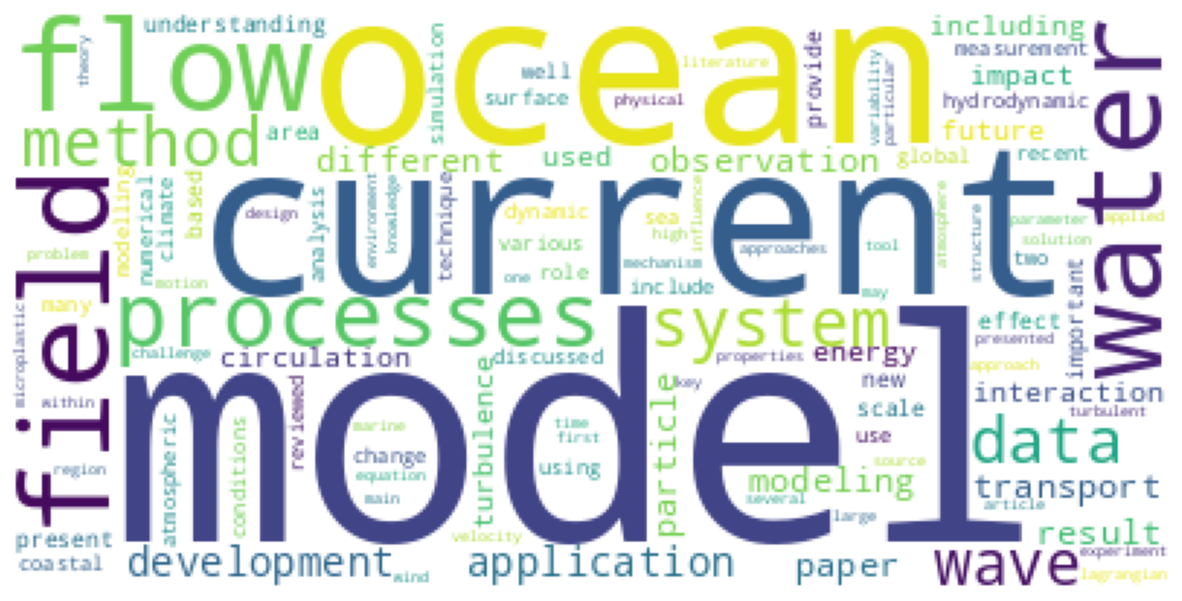

In [53]:
# Unimos el corpus en un string
long_string = ','.join(norm_corpus)
# Creamos un objeto wordcloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generamos una wordcloud
wordcloud = wordcloud.generate(long_string)
# Visualizamos el wordcloud
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [54]:
# Matriz de bolsa de documentos
def feature_extraction(corpus):
    bow = CountVectorizer(
        max_df=0.5
        )
    bow.fit(corpus)
    X_bow = bow.transform(corpus).toarray()
    return X_bow, bow 

In [55]:
# Bolsa de palabras
X_bow, bow = feature_extraction(norm_corpus)
X_bow.shape

(247, 6021)

In [105]:
lda = LatentDirichletAllocation(
    n_components=6,
    doc_topic_prior=1 / 20,
    topic_word_prior=1 / 20,
    random_state=42,
    ).fit(X_bow)

In [106]:
features_lda = lda.transform(X_bow)
print(features_lda.shape)

(247, 6)


In [107]:
# Listamos los topicos encontrados junto con los palabras mas fecuentes
terms = bow.get_feature_names_out()
for i, comp in enumerate(lda.components_):
    # Juntamos los términos con cada uno de los valores en la matriz V
    terms_comp = zip(terms, comp)
    # Ordenamos los términos de acuerdo al resultado de LSA
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    # Mostramos los términos más importantes en cada tópico
    print("Tópico {}: {}".format(i," ".join(list(map(lambda x:x[0], sorted_terms)))))

Tópico 0: models ocean carbon dust energy flows turbulent particles used water
Tópico 1: microplastics models velocity circulation microplastic ocean methods based jet future
Tópico 2: processes cfd current turbulence climate recent changes ocean computational new
Tópico 3: models model processes ocean surface sea current data transport coastal
Tópico 4: numerical model flow methods energy data paper time modeling within
Tópico 5: models current urban ocean observations circulation water north model paper


In [72]:
import pyLDAvis
import pyLDAvis.lda_model as sklearn_lda
import pickle

In [60]:
# Visualizamos lo topicos encontrados
pyLDAvis.enable_notebook()
LDAvis_data_filepath = "./ldavis_prepared"

In [108]:
X_bow = bow.transform(norm_corpus)
LDAvis_prepared = sklearn_lda.prepare(lda, X_bow, bow)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

In [109]:
with open(LDAvis_data_filepath,"rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, "./ldavis_prepared.html")
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.004814  0.032475       1        1  31.952206
0      0.055823 -0.150861       2        1  16.705868
5      0.028434  0.126396       3        1  15.437043
4      0.057008  0.057057       4        1  15.323922
2     -0.203667 -0.019772       5        1  10.698094
1      0.057588 -0.045295       6        1   9.882867, topic_info=               Term       Freq       Total Category  logprob  loglift
3404  microplastics  22.000000   22.000000  Default  30.0000  30.0000
710             cfd  32.000000   32.000000  Default  29.0000  29.0000
1603           dust  32.000000   32.000000  Default  28.0000  28.0000
769     circulation  65.000000   65.000000  Default  27.0000  27.0000
655          carbon  54.000000   54.000000  Default  26.0000  26.0000
...             ...        ...         ...      ...      ...      ...
1217        current   8.471039  116.682756   Topic6  -5.7786  -0.3084
1613       dynamics   7.969807   63.287273   Topic6  -5.8396   0.2423
5769           used   7.985462   79.359920   Topic6  -5.8377   0.0180
2052          field   7.941194   85.911464   Topic6  -5.8432  -0.0669
4307      processes   7.780878  116.437449   Topic6  -5.8636  -0.3913

[461 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
13        1  0.987188  absorption
73        2  0.968615      acuity
97        1  0.894359    adjacent
97        4  0.111795    adjacent
102       5  0.998165        adms
...     ...       ...         ...
5981      4  0.424054      within
5981      5  0.030290      within
5981      6  0.121158      within
5999      1  0.978201      wtebss
6011      4  0.973465    zanclean

[944 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 5, 3, 2])